In [1]:
import healpy as hp
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
%matplotlib inline 
# Import the NaMaster python wrapper
import pymaster as nmt

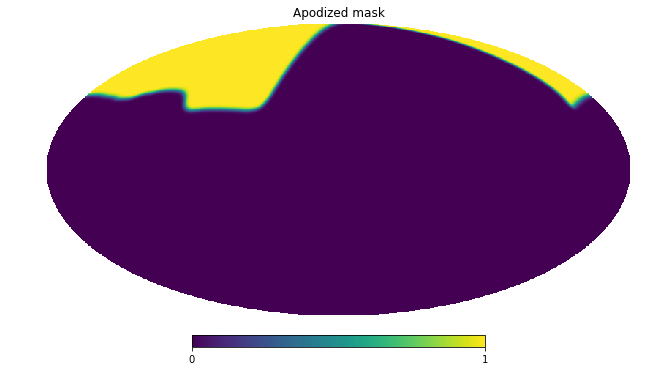

In [2]:
nside = 256
# Read mask and apodize it on a scale of ~1deg
mask = nmt.mask_apodization(hp.read_map("/smc/jianyao/Ali_maps/ali_mask_wo_edge.fits", verbose=False), 1., apotype="Smooth")
hp.mollview(mask, title='Apodized mask')

NSIDE = 256
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


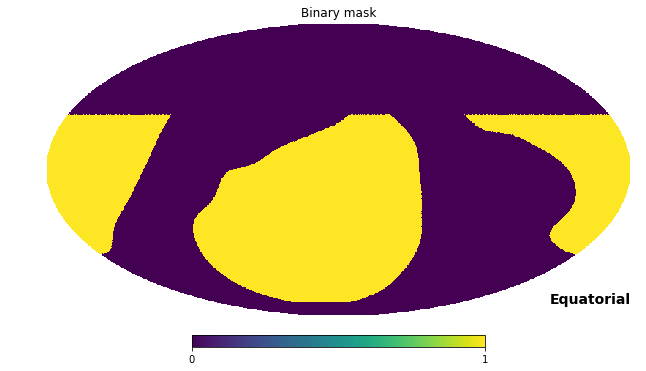

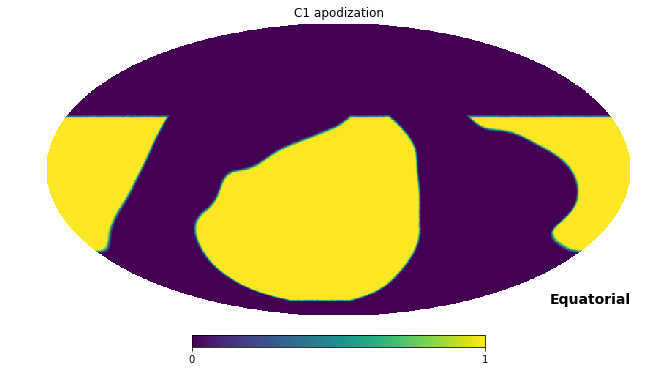

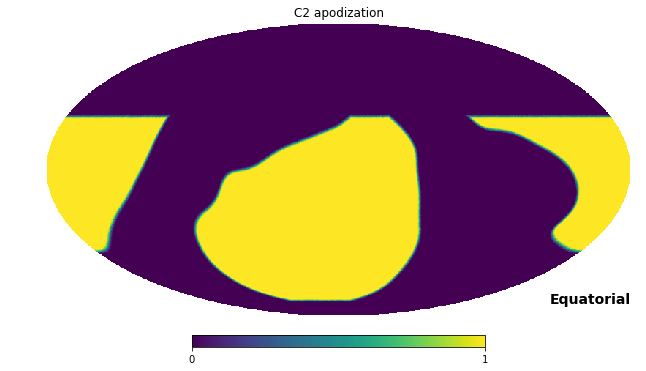

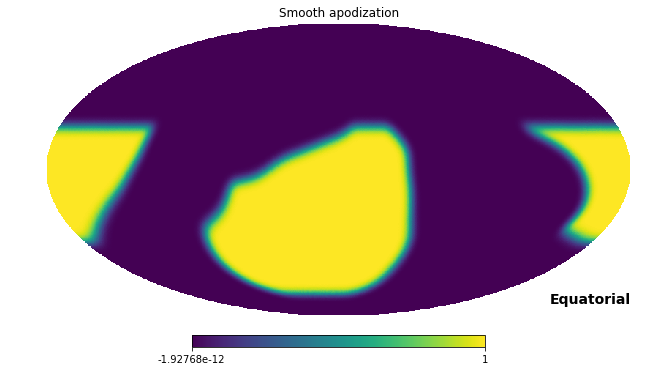

In [16]:
mask_raw = hp.read_map("/home/jianyao/NaMaster/test/mask.fits")

aposcale = 2.5

# C1 and C2: in these cases, pixels are multiplied by a factor f
#            (with 0<=f<=1) based on their distance to the nearest fully
#            masked pixel. The choices of f in each case are documented in
#            Section 3.4 of the C API documentation. All pixels separated
#            from any masked pixel by more than the apodization scale are
#            left untouched.
mask_C1 = nmt.mask_apodization(mask_raw, aposcale, apotype="C1")
mask_C2 = nmt.mask_apodization(mask_raw, aposcale, apotype="C2")

# Smooth: in this case, all pixels closer to a masked pixel than 2.5 times
#         the apodization scale are initially set to zero. The resulting
#         map is then smoothed with a Gaussian kernel with standard
#         deviation given by the apodization scale. Finally, all pixels
#         originally masked are forced back to zero.
mask_Sm = nmt.mask_apodization(mask_raw, aposcale, apotype="Smooth")

# Let's plot the results
hp.mollview(mask_raw, title='Binary mask', coord=['G', 'C'])
hp.mollview(mask_C1, title='C1 apodization', coord=['G', 'C'])
hp.mollview(mask_C2, title='C2 apodization', coord=['G', 'C'])
hp.mollview(mask_Sm, title='Smooth apodization', coord=['G', 'C'])

In [16]:
f_0 = nmt.NmtField(mask, [hp.read_map("/home/jianyao/NaMaster/test/maps.fits", field=0, verbose=False)])
f_2 = nmt.NmtField(mask, hp.read_map("/home/jianyao/NaMaster/test/maps.fits", field=[1, 2], verbose=False))

# Initialize binning scheme with 4 ells per bandpower
b = nmt.NmtBin(nside, nlb=4)

# Compute MASTER estimator
# spin-0 x spin-0
cl_00 = nmt.compute_full_master(f_0, f_0, b)
# spin-0 x spin-2
cl_02 = nmt.compute_full_master(f_0, f_2, b)
# spin-2 x spin-2
cl_22 = nmt.compute_full_master(f_2, f_2, b)

# Plot results
ell_arr = b.get_effective_ells()
plt.plot(ell_arr, cl_00[0], 'r-', label='TT')
plt.plot(ell_arr, np.fabs(cl_02[0]), 'g-', label='TE')
plt.plot(ell_arr, cl_22[0], 'b-', label='EE')
plt.plot(ell_arr, cl_22[3], 'y-', label='BB')
plt.loglog()
plt.xlabel('$\\ell$', fontsize=16)
plt.ylabel('$C_\\ell$', fontsize=16)
plt.legend(loc='upper right', ncol=2, labelspacing=0.1)

NameError: name 'nmt' is not defined

0 10
1 10
2 10
3 10
4 10
5 10
6 10
7 10
8 10
9 10


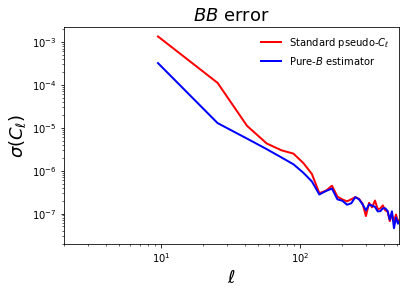

In [17]:
# We'll run this many simulations
nsim = 10
# HEALPix map resolution
nside = 256

# Let us first create a square mask:
msk = np.zeros(hp.nside2npix(nside))
th, ph = hp.pix2ang(nside, np.arange(hp.nside2npix(nside)))
ph[np.where(ph > np.pi)[0]] -= 2 * np.pi
msk[np.where((th < 2.63) & (th > 1.86) &
             (ph > -np.pi / 4) & (ph < np.pi / 4))[0]] = 1.

# Now we apodize the mask. The pure-B formalism requires the mask to be
# differentiable along the edges. The 'C1' and 'C2' apodization types
# supported by mask_apodization achieve this.
msk_apo = nmt.mask_apodization(msk, 10.0, apotype='C1')

# Select a binning scheme
b = nmt.NmtBin(nside, nlb=16)
leff = b.get_effective_ells()

# Read power spectrum and provide function to generate simulated skies
l, cltt, clee, clbb, clte = np.loadtxt('/home/jianyao/NaMaster/test/cls.txt', unpack=True)


def get_fields():
    mp_t, mp_q, mp_u = hp.synfast([cltt, clee, clbb, clte],
                                  nside=nside, new=True, verbose=False)
    # This creates a spin-2 field without purifying either E or B
    f2_np = nmt.NmtField(msk_apo, [mp_q, mp_u])
    # This creates a spin-2 field with both pure E and B.
    f2_yp = nmt.NmtField(msk_apo, [mp_q, mp_u], purify_e=True, purify_b=True)
    # Note that generally it's not a good idea to purify both,
    # since you'll lose sensitivity on E
    return f2_np, f2_yp


# We initialize two workspaces for the non-pure and pure fields:
f2np0, f2yp0 = get_fields()
w_np = nmt.NmtWorkspace()
w_np.compute_coupling_matrix(f2np0, f2np0, b)
w_yp = nmt.NmtWorkspace()
w_yp.compute_coupling_matrix(f2yp0, f2yp0, b)


# This wraps up the two steps needed to compute the power spectrum
# once the workspace has been initialized
def compute_master(f_a, f_b, wsp):
    cl_coupled = nmt.compute_coupled_cell(f_a, f_b)
    cl_decoupled = wsp.decouple_cell(cl_coupled)
    return cl_decoupled


# We now iterate over several simulations, computing the
# power spectrum for each of them
data_np = []
data_yp = []
for i in np.arange(nsim):
    print(i, nsim)
    fnp, fyp = get_fields()
    data_np.append(compute_master(fnp, fnp, w_np))
    data_yp.append(compute_master(fyp, fyp, w_yp))
data_np = np.array(data_np)
data_yp = np.array(data_yp)
clnp_mean = np.mean(data_np, axis=0)
clnp_std = np.std(data_np, axis=0)
clyp_mean = np.mean(data_yp, axis=0)
clyp_std = np.std(data_yp, axis=0)



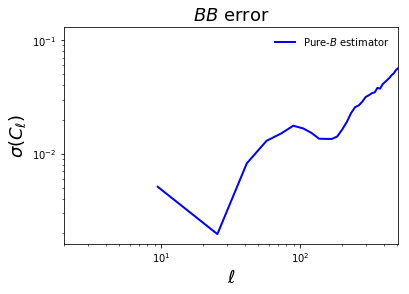

In [21]:
# Now we plot the results
plt.figure()
plt.title('$BB$ error', fontsize=18)
Ell = leff*(leff+1)/2/np.pi
# plt.plot(leff, Ell*clnp_mean[3], 'r-', lw=2, label='Standard pseudo-$C_\\ell$')
plt.plot(leff, Ell*clyp_mean[3], 'b-', lw=2, label='Pure-$B$ estimator')
plt.xlim([2, 512])
plt.xlabel('$\\ell$', fontsize=18)
plt.ylabel('$\\sigma(C_\\ell)$', fontsize=18)
plt.legend(loc='upper right', frameon=False)
plt.loglog()
plt.show()

In [19]:
leff

array([  9.5,  25.5,  41.5,  57.5,  73.5,  89.5, 105.5, 121.5, 137.5,
       153.5, 169.5, 185.5, 201.5, 217.5, 233.5, 249.5, 265.5, 281.5,
       297.5, 313.5, 329.5, 345.5, 361.5, 377.5, 393.5, 409.5, 425.5,
       441.5, 457.5, 473.5, 489.5, 505.5, 521.5, 537.5, 553.5, 569.5,
       585.5, 601.5, 617.5, 633.5, 649.5, 665.5, 681.5, 697.5, 713.5,
       729.5, 745.5])

In [3]:
import numpy as np

In [12]:
x = np.array((1.2,2.23,-1.23))

In [15]:
all(x/abs(x) + 1)

False

In [7]:
x.astype(bool)

array([ True,  True, False])

In [11]:
all